<h2> Homework 1 Part B </h2>
<i> Gawan Dekker 11025654, Marvin Lau 12364282, Bobbie van Gorp 11161108</i>

<h2> Implementation including documentation </h2>

In [77]:
# Imports
import numpy as np
from random import random
import matplotlib.pyplot as plt
from scipy import stats, sqrt
from math import ceil

plt.rcParams["figure.figsize"] = [20,10]
params = {'legend.fontsize': 20}
plt.rcParams.update(params)

<h3> Step 1: Generate rankings </h3>

In [78]:
def gen_input_unsorted(length, n):
    """Creates a list of all possible combinations of relevance scores.
    
    Parameters
    ----------
    length : int
        Length of a combination of relevance scores.
    n : int
        Maximum relevance score
    
    Returns
    -------
    out : list
        A list containing all possible combinations of relevance scores.
    """
    out = []
    out.append([0] * length)
    for i in range(length):
        for j in range(1, n):
            affix = [0] * i + [j]
            suffixes = gen_input_unsorted(length - (i + 1), n)
            for suffix in suffixes:
                out.append(affix + suffix)
    return out

def gen_input(length, n):
    """Creates a sorted list of all possible combinations
    of relevance scores.
    
    Parameters
    ----------
    length : int
        Length of a combination of relevance scores.
    n : int
        Maximum relevance score
    
    Returns
    -------
    out : list
        A sorted list containing all possible combinations
        of relevance scores.
    """
    if length > 0:
        out = gen_input_unsorted(length, n)
        out.sort()
    else:
        out = []
    return out

def gen_input_pairs(length, n):
    """Creates a sorted list of all possible pairs of combinations
    of relevance scores.
    
    Parameters
    ----------
    length : int
        Length of a combination of relevance scores.
    n : int
        Maximum relevance score
    
    Returns
    -------
    out : list
        A sorted list containing all possible pairs of combinations
        of relevance scores.
    """
    out = gen_input(length * 2, n)
    for i in range(len(out)):
        out[i] = (out[i][:length], out[i][length:])
    return out


def get_conflicts(n, length, _in=[], ordered=False):
    """Creates a list of all possible id conflicts.
    
    Parameters
    ----------
    n : int
        Total possible number of id conflicts at a time.
    length: int
        Length of the list containing id conflicts.
    _in : array_like
        Array of current id conflicts.
    ordered : bool
        Indicates whether id conflict numbers are to appear in order
        or are permitted to appear in any order.
    
    Returns
    -------
    out : list
        A list containing all possible id conflicts.
        A value of 0 indicates no conflict,
        a value higher than indicates a conflict.
    """
    if (len(_in) < length and n <= length):
        out = []
        # Add all possible conflicts.
        for i in [x for x in range(1, n + 1) if x not in _in]:
            out += get_conflicts(n, length, _in + [i], ordered)
            if ordered:
                break
        # Add absence of a conflict if possible.
        if (length - len(_in) > n - sum([1 for i in _in if i != 0])):
            out += get_conflicts(n, length, _in + [0], ordered)
        return out
    else:
        return [_in]

def add_conflicts(pair):
    """Adds id conflicts to a tuple of combinations of relevance grades.
    
    Parameters
    ----------
    pair : tuple
        Tuple of combinations of relevance grades.
    
    Returns
    -------
    out : list
        A list of all possible tuples of combinations
        of relevance grades with id conflicts.
        Relevance grades from the inputs have been replaced by a tuple
        of relevance grade and id conflict number.
    """
    out = []
    # Add all possible id conflicts to input pair.
    for n in range(len(pair[0]) + 1):
        for ids0 in get_conflicts(n, len(pair[0]), ordered=True):
            ranking0 = list(zip(pair[0], ids0))
            for ids1 in get_conflicts(n, len(pair[0])):
                out.append((ranking0, list(zip(pair[1], ids1))))
    # Remove any pairs in which conflicts appear
    # where relevance grades do not match.
    for i in range(len(out) - 1, -1, -1):
        delete = False
        for r0, id0 in out[i][0]:
            if id0 > 0:
                for r1, id1 in out[i][1]:
                    if id0 == id1 and not r0 == r1:
                        delete = True
                        break
            if delete:
                out.pop(i)
                break
    return out

<h3> Step 2: Calculate ERR </h3>

In [79]:
def ERR(g_list, R_func=lambda g, max_g: float(2**g- 1) / 2**max_g):
    """Calculates Expected Reciprocal Rank for one list
    of relevance grades.
    
    Source
    ------
    The algorithm originates from a paper by O. Chapelle et al.
    named "Expected Reciprocal Rank for Graded Relevance"
    and can be found here: http://olivier.chapelle.cc/pub/err.pdf
    
    Parameters
    ----------
    g_list : array_like
        Array of relevance grades.
    R_func : function(int, int) -> float
        Function that converts a relevance grade
        to probability of relevance.
    
    Returns
    -------
    ERR : float
        Expected Reciprocal Rank.
    """
    p = 1
    ERR = 0
    max_g = max(g_list)
    for r in range(1, len(g_list) + 1):
        R = R_func(g_list[r - 1], max_g)
        ERR += p * R / float(r)
        p *= 1 - R
    return ERR

<h3>Step 3: Interleaving </h3>

In [80]:
def td_interleaving(ranking_pair,max_interleav=3):
    """Run Team-draft interleaving given a ranking pair as input

    Parameters
    ----------
    An ranking pair : List of ranked and labeled results
        Index of list elements represents the rank of that element. Each
        element is a tuple of the relevance score and a duplicate ID.
        If this value is 0, it has no duplicate with a document in the results of other ranker.
        If the value is greater than 0, then it has a duplicate with another result of the other ranker that matches this number
        No duplicate example: E ranked list:  [(0,0),(0,0),(0,0)] and P ranked list: [(1,0),(0,0),(0,0)] form
        2 duplicates example: E ranked list: [(1,1),(0,2),(0,0)]  and P ranked list: [(1,0),(1,1),(0,2)]  for example
    Returns
    -------
    Interleaved list (of length 3 as default) based on Team-draft method: list
        Index + 1 represents the rank of the interleaved list and element is an tuple of the form (relevance: binary,ranker credit:binary), Credits are assigned as P(0) and E(1)
    """
    ranking_p = ranking_pair[0] #[(0,0),(0,0),(0,0)] form or duplicate [(0,1),(0,0),(0,0)]
    ranking_e = ranking_pair[1]
    interleaved = []

    p_team = 0 #Amount results assigned from p
    e_team = 0
    p_pointer = 0 #Next top result from ranking p
    e_pointer = 0
    found_duplicates = [] #Duplicate documents have an ID of greater than 0. A matching number is an duplciate
    limit = len(ranking_p)

    #while p_pointer < limit and e_pointer < limit:
    while len(interleaved) < max_interleav:

        p_priority = np.random.choice(2, 1)[0]
        new_result = False
        if (p_team < e_team) or (p_team == e_team and p_priority == 1):

            while not new_result:
                top_result_p = ranking_p[p_pointer]
                relevance_p, duplicate_id_p = top_result_p

                p_pointer += 1
                if duplicate_id_p not in found_duplicates:
                    new_result = True
                    break
                elif p_pointer == limit:
                    break

            if new_result:
                #interleaved.append( (relevance_p,"P") )
                interleaved.append((relevance_p, 0))
                p_team += 1

                if duplicate_id_p > 0:
                    found_duplicates.append(duplicate_id_p)
        else:

            while not new_result:
                top_result_e = ranking_e[e_pointer]
                relevance_e, duplicate_id_e = top_result_e
                e_pointer += 1

                if duplicate_id_e not in found_duplicates:
                    new_result = True
                    break
                elif e_pointer == limit:
                    break

            if new_result:
                #interleaved.append((relevance_e, "E"))
                interleaved.append((relevance_e, 1))
                e_team += 1

                if duplicate_id_e > 0:
                    found_duplicates.append(duplicate_id_e)

    return interleaved

def get_softmax(ranking_indices,tau):
    """Compute softmax distribution for a ranker given the indices of documents that are avaliable to be picked.

    Parameters
    ----------
    Ranking indices : List of indices that represent the rank of documents that can be picked for next interleaving.
    Example of nothing picked of ranker: List of the form: [0,1,2]
    Example of document already picked of ranker: List of the form: [0,2]

    Returns
    -------
    List of softmax probabilities for documents to be picked: List
        The list maps one to one the ranking indices that were given as input, each element is a probability for the document for that particular index
        in that ranking indices list, which in turn consist of numbers that represents the actual indices to be picked from ranked results.

    """

    numerator_list = [] #Numerator values for each of the ranked results
    softmax_distribution = []

    for rank_index in ranking_indices:
        rank = rank_index + 1
        numerator_value = 1/(rank**tau)
        numerator_list.append(numerator_value)

    denominator = sum(numerator_list)

    for value in numerator_list:
        probability = value/denominator
        softmax_distribution.append(probability)

    return softmax_distribution

def prob_interleaving(ranking_pair,max_interleav=3,tau=3):
    """Run Probabilistic interleaving  given a ranking pair as input

    Parameters
    ----------
    An ranking pair : List of ranked and labeled results
        Index of list elements represents the rank of that element. Each
        element is a tuple of the relevance score and a duplicate ID.
        If this value is 0, it has no duplicate with a document in the results of other ranker.
        If the value is greater than 0, then it has a duplicate with another result of the other ranker that matches this number
        No duplicate example: E ranked list:  [(0,0),(0,0),(0,0)] and P ranked list: [(1,0),(0,0),(0,0)] form
        2 duplicates example: E ranked list: [(1,1),(0,2),(0,0)]  and P ranked list: [(1,0),(1,1),(0,2)]  for example
    Returns
    -------
    Interleaved list (of length 3 as default) based on probabilistc interleaving method: list
        Index + 1 represents the rank of the interleaved list and element is an tuple of the form (relevance: binary,ranker credit:binary), credits are assigned as P(0) and E(1)
    """

    ranking_p = ranking_pair[0] #[(0,0),(0,0),(0,0)] form or duplicate [(0,1),(0,0),(0,0)]
    ranking_e = ranking_pair[1] #[(0,0),(0,0),(0,0)] form or duplicate #[(0,1),(0,0),(0,0)]
    interleaved = []
    limit = len(ranking_p)

    p_indices = list(range(limit))
    e_indices = list(range(limit))

    found_duplicates = []

    #while len(p_indices) > 0 or len(e_indices) > 0:
    while len(interleaved) < max_interleav:

        p_priority = np.random.choice(2, 1)[0]

        if (p_priority and len(p_indices) > 0) or len(e_indices) == 0:
            softmax_p = get_softmax(p_indices,tau)
            doc_index_p = np.random.choice(p_indices, 1, p=softmax_p)[0]
            p_indices.remove(doc_index_p)

            result_p = ranking_p[doc_index_p]
            relevance_p, duplicate_id_p = result_p

            if duplicate_id_p == 0 :
                #interleaved.append((relevance_p, "P"))
                interleaved.append((relevance_p, 0))
            elif (duplicate_id_p > 0 and duplicate_id_p not in found_duplicates):
                #interleaved.append((relevance_p, "P"))
                interleaved.append((relevance_p, 0))
                found_duplicates.append(duplicate_id_p)
                duplicate_index = ranking_e.index(result_p)
                e_indices.remove(duplicate_index)
        else:
            softmax_e = get_softmax(e_indices,tau)
            doc_index_e = np.random.choice(e_indices, 1, p=softmax_e)[0]
            e_indices.remove(doc_index_e)

            result_e = ranking_e[doc_index_e]
            relevance_e, duplicate_id_e = result_e

            if duplicate_id_e == 0:
                #interleaved.append((relevance_e, "E"))
                interleaved.append((relevance_e, 1))
            elif (duplicate_id_e > 0 and duplicate_id_e not in found_duplicates):
                #interleaved.append((relevance_e, "E"))
                interleaved.append((relevance_e, 1))
                found_duplicates.append(duplicate_id_e)
                duplicate_index = ranking_p.index(result_e)
                p_indices.remove(duplicate_index)

    return interleaved

<h3> Step 4: Click Models </h3>

In [81]:
def read_yandex(path, n=-1):
    """Reads yandex database.
    
    Parameters
    ----------
    path : str
        Path to database file.
    n : int
        Number of lines to read. Is ignored if value is lower than 0.
    
    Returns
    -------
    out : list
        A list of dictionaries representing database entries.
    """
    out = []
    with open(path) as f:
        for i, l in enumerate(f):
            if n >= 0 and i > n:
                break
            data = l.strip().split('\t')
            item = {
                'id'   : int(data[0]),
                't'    : int(data[1]),
                'a'    : data[2].lower(),
                'a_id' : int(data[3])
            }
            if item['a'] == 'q':
                item['r_id'] = int(data[4])
                item['urls'] = [int(x) for x in data[5:]]
            out.append(item)
    return out


class RCM:
    """Random Click Model
    ==================
    
    Click model that simulates user interaction as random clicking.
    
    One parameter `rho` is learned signifying the chance
    of a document being clicked. User interaction is then simulated
    by comparing a random value drawn from a uniform distribution
    against this `rho` value.
    """
    def __init__(self):
        """Initializes class parameters.
        """
        self.rho = random()
    
    def learn(self, database, n=-1):
        """Learns class parameters.
        
        Parameters
        ----------
        database : array_like
            Array of dictionaries representing database items.
        n : int
            Maximum rank at which parameters are learned.
        
        Returns
        -------
        None
        """
        n_clicks, n_docs = 0, 0
        for item in database:
            if item['a'] == 'q':
                if n < 0:
                    n_docs += len(item['urls'])
                else:
                    n_docs += len(item['urls'][:n])
            else:
                n_clicks += 1
        self.rho = n_clicks / float(n_docs)
        return
    
    def get_p(self, relevance_grades):
        """Determines chance of clicking on a document.
        
        Parameters
        ----------
        relevance_grades : array_like
            Array containing relevance grades for all documents
            returned by a search query.
        
        Returns
        -------
        out : list
            List of probabilities corresponding
            to entries in `search_results`.
        """
        out = [self.rho for _ in range(len(relevance_grades))]
        return out
    
    def get_clicks(self, relevance_grades):
        """Simulate user interaction by determining
        what documents are clicked on.
        
        Parameters
        ----------
        relevance_grades : array_like
            Array containing relevance grades for all documents
            returned by a search query.
        
        Returns
        -------
        out : list
            List of indices of the documents that were clicked on
            in the simulation.
        """
        p = self.get_p(relevance_grades)
        out = []
        for i in range(len(p)):
            if random() <= p[i]:
                out.append(i)
        return out


class PBM:
    """Position Based Click Model
    ==========================
    
    Click model that simulates user interaction
    based on rank and document score.
    
    Two sets of parameters are learned, `alphas` and `gammas`.
    Parameters in `alphas` represent the attractiveness of documents
    given a certain query, while parameters in `gammas` represent
    the chance of viewing a document at a specific rank.
    User interaction is simulated by comparing a random value
    drawn from a uniform distribution against the product of
    one of the parameters in `gammas` and a value `epsilon`.
    Here `epsilon` represents the chance of clicking on a document
    even though the document is irrelevant and vice versa (`epsilon` replaces
    the parameters in `alpha` due to data sparcity).
    """
    def __init__(self):
        """Initializes class parameters.
        """
        self.alphas = {}
        self.gammas = []
    
    def update(self, item, alpha_sum, gamma_sum, prev_q, clicks, n=-1):
        """Updates sum of alpha and gamma contributions
        for the previous query database item.
        
        Parameters
        ----------
        item : dict
            A dictionary representing a database item.
        alpha_sum : dict
            A dictionary containing the summed contributions and
            number of contributions for all alphas corresponding
            to a document and query pair.
        gamma_sum : array_like
            A list containing the summed contributions of all gammas
            corresponding to a rank.
        prev_q : dict
            A dictionary representing the previous query database item.
        clicks : array_like
            A list of documents ids, returned by the last query,
            that the user clicked on.
        n : int
            Maximum rank at which parameters are learned.
        
        Returns
        -------
        alpha_sum : dict
            A dictionary containing the summed contributions and
            number of contributions for all parameters in `alphas`
            corresponding to a document and query pair.
        gamma_sum : array_like
            A list containing the summed contributions for all
            parameters in `gammas` corresponding to a rank.
        prev_q : dict
            A dictionary representing the previous query database item.
        clicks : array_like
            A list of documents ids, returned by the last query,
            that the user clicked on.
        """
        if item['a'] == 'q':
            q_id = prev_q['a_id']
            q_urls = prev_q['urls']
            if n >= 0:
                q_urls = q_urls[:n]
            gamma_length = len(q_urls)
            # Extend gammas and gamma_sum.
            while len(self.gammas) < gamma_length:
                self.gammas.append(random())
            while len(gamma_sum) < gamma_length:
                gamma_sum.append(0)
            for r, _id in enumerate(q_urls):
                uq = str((_id, q_id))
                # Extend alphas and alpha_sum.
                if self.alphas.get(uq) == None:
                    self.alphas[uq] = random()
                if alpha_sum.get(uq) == None:
                    alpha_sum[uq] = {'sum' : 0, 'length' : 0}
                # Update alphs_sum and gamma_sum.
                if _id in clicks:
                    alpha_sum[uq]['sum'] += 1
                    gamma_sum[r] += 1
                else:
                    alpha_sum[uq]['sum'] += \
                        (1 - self.gammas[r]) * self.alphas[uq] \
                        / (1 - self.gammas[r] * self.alphas[uq])
                    gamma_sum[r] += \
                        self.gammas[r] * (1 - self.alphas[uq]) \
                        / (1 - self.gammas[r] * self.alphas[uq])
                alpha_sum[uq]['length'] += 1
            prev_q = item
            clicks = []
        else:
            # Record clicked document id.
            clicks.append(item['a_id'])
        return alpha_sum, gamma_sum, prev_q, clicks
    
    def _learn(self, database, n=-1):
        """Learns class parameters for one run over the given database.
        
        Parameters
        ----------
        database : array_like
            Array of dictionaries representing database items.
        n : int
            Maximum rank at which parameters are learned.
        
        Returns
        -------
        None
        """
        alpha_sum = {}
        gamma_sum = []
        prev_q = database[0]
        session_id = prev_q['id']
        clicks = []
        
        empty_q = {'id' : -1, 'a' : 'q', 'a_id' : -1, 'urls' : []}
        
        # Adjust query counter for empty query.
        n_queries = 0
        if prev_q['a'] != 'q':
            n_queries -= 1
        
        # Sum alpha and gamma contributions
        # of each item in the database.
        for item in database[1:] + [empty_q]:
            if item['a'] == 'q':
                n_queries += 1
            if session_id != item['id']:
                alpha_sum, gamma_sum, prev_q, clicks = self.update(
                    empty_q, alpha_sum, gamma_sum, prev_q, clicks, n)
                session_id = item['id']
            alpha_sum, gamma_sum, prev_q, clicks = self.update(
                item, alpha_sum, gamma_sum, prev_q, clicks, n)
        
        # Update alphas and gammas.
        for uq, alpha in alpha_sum.items():
            self.alphas[uq] = (alpha['sum'] + 1) \
                / float(alpha['length'] + 2)
        for r, gamma_sum_r in enumerate(gamma_sum):
            self.gammas[r] = (gamma_sum_r + 1) / float(n_queries + 1)
        
        return
    
    def learn(self, database, n_decimals, n_consecutive, n_rank=-1):
        """Learns class parameters on the given database
        until convergence.
        
        Parameters
        ----------
        database : array_like
            Array of dictionaries representing database items.
        n_decimals : int
            Number of decimals on which convergence is checked.
        n_consecutive : int
            Number of consecutive database iterations for which
            convergence is checked.
        n_rank : int
            Maximum rank at which parameters are learned.
        
        Returns
        -------
        None
        """
        prev_gammas = []
        convergence = False
        while convergence == False:
            self._learn(database, n_rank)
            prev_gammas.append(
                [round(gamma, n_decimals) for gamma in self.gammas])
            if len(prev_gammas) >= n_consecutive:
                while len(prev_gammas) > n_consecutive:
                    prev_gammas.pop(0)
                convergence = True
                for prev, cur in zip(prev_gammas[:-1], prev_gammas[1:]):
                    for gamma_prev, gamma_cur in zip(prev, cur):
                        if gamma_prev - gamma_cur != 0:
                            convergence = False
                            break
                    if convergence == False:
                        break
        return
    
    def get_p(self, relevance_grades, epsilon=1e-1):
        """Determines chance of clicking on a document.
        
        Parameters
        ----------
        relevance_grades : array_like
            Array containing relevance grades for all documents
            returned by a search query.
        epsilon : float
            Value representing the chance of clicking on a document
            even though the document is irrelevant and vice versa.
        
        Returns
        -------
        out : list
            List of probabilities corresponding
            to entries in `search_results`.
        """
        out = []
        for i in range(min(len(self.gammas), len(relevance_grades))):
            if relevance_grades[i] == 0:
                out.append(self.gammas[i] * epsilon)
            else:
                out.append(self.gammas[i] * (1 - epsilon))
        return out
    
    def get_clicks(self, relevance_grades, epsilon=1e-1):
        """Simulate user interaction by determining
        what documents are clicked on.
        
        Parameters
        ----------
        relevance_grades : array_like
            Array containing relevance grades for all documents
            returned by a search query.
        epsilon : float
            Value representing the chance of clicking on a document
            even though the document is irrelevant and vice versa.
        
        Returns
        -------
        out : list
            List of indices of the documents that were clicked on
            in the simulation.
        """
        p = self.get_p(relevance_grades)
        out = []
        for i in range(len(p)):
            if random() <= p[i]:
                out.append(i)
        return out


<h3> Step 5: Simulate interleaving experiment </h3>

In [82]:
def interleaving_simulation(pair, k, interleaving_func, click_model_func, length_interleaving=-1):
    """Simulates user interaction on interleaved search results.

    Parameters
    ----------
    pair : tuple
        Pair of ranking combinations.
    k : int
        Number of simulations.
    interleaving_func : function(tuple) -> list
        Function to interleave the two lists of ranking combinations.
    click_model : function(array_like) -> int
        Function to simulate user click.

    Returns
    -------
    p : float
        Proportion of wins of second ranking combination in pair.
    """
    wins = [0] * len(pair)
    while sum(wins) == 0:
        for _ in range(k):
            # Create interleaved list
            search_results = interleaving_func(pair,
                length_interleaving)
            # Get relevance label of documents in interleaved list
            relevance_grades = []
            for relevance, assignment in search_results:
                relevance_grades.append(relevance)
            # Get clicked documents indices from interleaved list
            clicked = click_model_func(relevance_grades)
            n_E_click = 0
            n_P_click = 0
            # Determine who got most clicks
            for click in clicked:
                assignment = search_results[click][1]
                if assignment == 1:
                    n_E_click += 1
                else:
                    n_P_click += 1

            if n_E_click == n_P_click:
                continue
            elif n_E_click > n_P_click:
                wins[1] += 1
            else:
                wins[0] += 1

    p = wins[1] / float(wins[0] + wins[1])
    return p

<h3> Step 6: Compute sample size </h3>

In [83]:
def compute_sample_size(p1, alpha=0.05, beta=0.10):
    """Computes sample size for a given proportion
    based on power analysis. Returns -1 if p1 == 0.5.
    
    Parameters
    ----------
        p1 : float
            Proportion for which sample size is to be calculated.
        alpha : float
            Type I error parameter.
        beta : float
            Type II error parameter.
    
    Returns
    -------
        n : int
            Sample size.
    """
    p0 = 0.5
    # Return -1 if given proportion is exactly 50%.
    diff = p1 - p0
    if diff == 0:
        return -1
    # Compute sample size.
    z_alpha = stats.norm.ppf(1 - alpha)
    z_beta = stats.norm.ppf(1 - beta)
    sigma0 = sqrt(p0 * (1 - p0))
    sigma1 = sqrt(p1 * (1 - p1))
    n = ((z_alpha * sigma0 + z_beta * sigma1) / diff) ** 2
    return ceil(n)


def get_bin_labels(n_bins, n_decimals=3, cut_sides=0.0):
    """Creates labels containing ranges for bins.
    
    Parameters
    ----------
    n_bins : int
        Amount of bins to label.
    n_decimals : int
        Number of decimals to round the ranges on.
    cut_sides : float
        Amount by which first and last bin have their ranges cut.
    
    Returns
    -------
    out : list
        A list containing labels.
    """
    out = []
    step = 1.0 / n_bins
    for i in range(n_bins):
        # Determine delta range of bin.
        dmin = i * step
        dmax = dmin + step
        if i == 0:
            dmin += cut_sides
        if i == n_bins - 1:
            dmax -= cut_sides
        dmin = round(dmin, n_decimals)
        dmax = round(dmax, n_decimals)
        out.append('(' + str(dmin) + ' - ' + str(dmax) + ']')
    return out

def process_bins(bins):
    """Determines minimum value, maximum value and median
    for each of the given bins.
    
    Parameters
    ----------
    bins : array_like
        Array of bins containing numerical values.
    
    Returns
    -------
    out : list
        A list of dictionaries containing the minimum value,
        maximum value and median for each bin.
    """
    out = []
    for cur in bins:
        if cur == []:
            out.append({'has_info' : False})
        else:
            # Sort bin and remove error-data.
            cur.sort()
            cur.reverse()
            while cur[-1] == -1:
                cur.pop()
            cur.reverse()
            # Determine minimum, median and maximum.
            d, m = divmod(len(cur), 2)
            median = ceil((cur[d] + cur[-int(not bool(m))]) / 2.0)
            out.append({'min' : min(cur), 'max' : max(cur),
                'median' : median, 'has_info' : True})
    return out

def print_bin_info(bin_info, labels=None):
    """Prints minimum value, median and maximum value
    for each of the given bin info dictionaries.
    
    Parameters
    ----------
    bins : array_like
        Array of dictionaries containing `min`, `max` and `median`
        fields, also contains a `has_info` field which is to be turned
        set `False` if not all other fields are present.
        
    Returns
    -------
    None
    """
    if labels == None:
        labels = list(range(len(bin_info)))
    for info, label in zip(bin_info, labels):
        print('BIN', label)
        if info['has_info']:
            print('     min', info['min'])
            print('  median', info['median'])
            print('     max', info['max'])
        else:
            print('  NO DATA')
        print()
    return


def plot_bin_info(bin_info_list, bin_set_labels=[], bin_labels=[]):
    """Plots min/median/max information for the bins
    in the given bin sets.
    
    Parameters
    ----------
    bin_info_list : array_like
        A list of sets of bins containing dictionaries
        with min/median/max/has_info information.
    bin_set_labels : array_like
        A list of labels for the different sets of bins.
    bin_labels : array_like
        A list of labels of the different bins in the bin sets.
        Is used to label the x axis.
    
    Returns
    -------
    None
    """
    if bin_set_labels == []:
        bin_set_labels = list(range(len(bin_info_list)))
    # Plot median with min and max as error bars
    # for each bin in each bin set.
    for i, (bin_info, label) in enumerate(zip(bin_info_list, bin_set_labels)):
        x = [j + 0.1 * (i + 1) for j in range(len(bin_info))]
        y = [info['median'] if info['has_info'] else 0 for info in bin_info]
        err = ([info['median'] - info['min'] if info['has_info'] else 0
            for info in bin_info],
            [info['max'] - info['median'] if info['has_info'] else 0
            for info in bin_info])
        plt.errorbar(x, y, err, label=label)
    # Apply bin labels.
    if bin_labels != []:
        plt.xticks(range(len(bin_labels)), bin_labels + [''], rotation=30)
    plt.legend()
    plt.xlabel('$\Delta$ERR', fontsize=17)
    plt.ylabel('sample size', fontsize=17)
    plt.title('Determined sample size', fontsize=22)
    plt.tight_layout()
    plt.show()
    return

<h3> Execution </h3>

In [84]:
length_interleaving = 3

inputs = gen_input_pairs(length_interleaving, 2)

#Click model training
#print('LOG :: TRAINING')
rcm = RCM()
pbm = PBM()
database = read_yandex("./YandexRelPredChallenge.txt")
rcm.learn(database, length_interleaving)
pbm.learn(database, 3, 5, length_interleaving)
#print('LOG :: DONE TRAINING')

n_simulations = 2000
click_model_fs = [rcm.get_clicks, pbm.get_clicks]
interleaving_fs = [td_interleaving, prob_interleaving]
bin_set_labels = [
    'RCM & Team-Draft Interleaving',
    'RCM & Probabilistic Interleaving',
    'PBM & Team-Draft Interleaving',
    'PBM & Probabilistic Interleaving'
]

n_bins = 10
cut_sides = 0.05
bins = [[[] for _ in range(n_bins)]
    for _ in range(len(bin_set_labels))]

for l, pair in enumerate(inputs):

    #print('LOG :: ' + str(l + 1) + ' / ' + str(len(inputs))
    #    + ' INPUTS')

    dERR = ERR(pair[1]) - ERR(pair[0])
    if dERR > cut_sides and dERR <= 1.0 - cut_sides:

        for i, click_model_f in enumerate(click_model_fs):
            for j, interleaving_f in enumerate(interleaving_fs):

                ij = i*len(interleaving_fs)+j
                #print('  LOG :: ' + str(ij + 1) + ' / '
                #    + str(len(bins)) + ' BINS')

                permutations = add_conflicts(pair)

                for k, permutation in enumerate(permutations):

                    #print('    LOG :: ' + str(k + 1) + ' / '
                    #   + str(len(permutations)) + ' PERMUTATIONS')

                    p = interleaving_simulation(
                        permutation, n_simulations,
                        interleaving_f, click_model_f,
                        length_interleaving)
                    bins[ij][int(dERR * 10)].append(
                        compute_sample_size(p))   


<h3>Step 7: Analysis </h3>

In [85]:
bin_sets = []
bin_labels = get_bin_labels(n_bins)
keys = ["min","median","max"]
name_counter = 0
ranges = ["[0.05, 0.1)","[0.1, 0.2)","[0.2, 0.3)","[0.3, 0.4)","[0.4, 0.5)","[0.5, 0.6)","[0.6, 0.7)","[0.7, 0.8)","[0.8, 0.9)","[0.9, 0.95)]"]
for bin_set, label in zip(bins, bin_set_labels):
    #print('===== ' + label + ' =====')
    bin_info = process_bins(bin_set)
    #print_bin_info(bin_info)
    bin_sets.append(bin_info)
    
    table = [[None,None,bin_set_labels[name_counter],None],["$\Delta ERR$","Min","Median","Max"]]
    name_counter +=1
    for bin_index,bin_range in enumerate(ranges):
        row = [bin_range]
        info = bin_info[bin_index]
        if len(info) > 1:
            for key in keys:
                sample_size = info[key] 
                row.append(sample_size)
            table.append(row)
        else:
            table.append(row + ["No Data","No Data","No Data"])
    display(HTML(tabulate.tabulate(table, tablefmt='html')))    

,,RCM & Team-Draft Interleaving,
$\Delta ERR$,Min,Median,Max
"[0.05, 0.1)",33,256,10487
"[0.1, 0.2)",41,4901,9323
"[0.2, 0.3)",31,5516,10487
"[0.3, 0.4)",50,6100,11721
"[0.4, 0.5)",43,5699,10487
"[0.5, 0.6)",38,292,11721
"[0.6, 0.7)",64,377,10487
"[0.7, 0.8)",No Data,No Data,No Data
"[0.8, 0.9)",No Data,No Data,No Data


,,RCM & Probabilistic Interleaving,
$\Delta ERR$,Min,Median,Max
"[0.05, 0.1)",60,4901,9323
"[0.1, 0.2)",83,4870,9323
"[0.2, 0.3)",74,6696,13022
"[0.3, 0.4)",74,6442,11721
"[0.4, 0.5)",49,5589,10487
"[0.5, 0.6)",43,5414,10487
"[0.6, 0.7)",66,266,8227
"[0.7, 0.8)",No Data,No Data,No Data
"[0.8, 0.9)",No Data,No Data,No Data


,,PBM & Team-Draft Interleaving,
$\Delta ERR$,Min,Median,Max
"[0.05, 0.1)",12,3720,7199
"[0.1, 0.2)",3,23,2472
"[0.2, 0.3)",3,7,1444
"[0.3, 0.4)",3,6,545
"[0.4, 0.5)",3,11,15
"[0.5, 0.6)",3,5,9
"[0.6, 0.7)",7,7,11
"[0.7, 0.8)",No Data,No Data,No Data
"[0.8, 0.9)",No Data,No Data,No Data


,,PBM & Probabilistic Interleaving,
$\Delta ERR$,Min,Median,Max
"[0.05, 0.1)",9,147,11721
"[0.1, 0.2)",3,34,13022
"[0.2, 0.3)",7,7219,14393
"[0.3, 0.4)",9,17,416
"[0.4, 0.5)",7,29,41
"[0.5, 0.6)",3,6,34
"[0.6, 0.7)",6,8,17
"[0.7, 0.8)",No Data,No Data,No Data
"[0.8, 0.9)",No Data,No Data,No Data


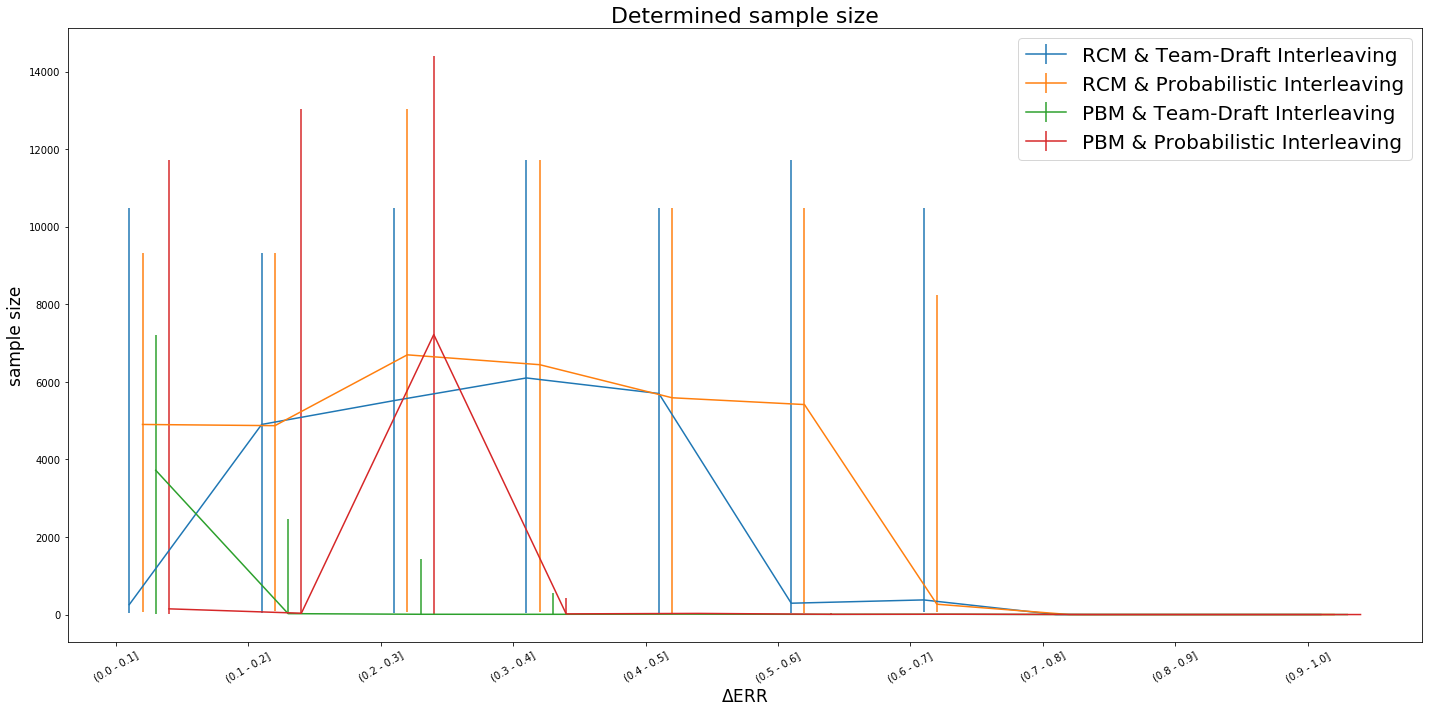

In [87]:
plot_bin_info(bin_sets, bin_set_labels, bin_labels)